#### About Project:
#### This is a Machine Learning course project to study causality between social networks and adoption of commercial lending.
##### **All data used in this project is from Banerjee, Chandrasekhar, Duflo, Jackson 2012: Social networks in India and Microfinance Adoption.

In [1]:
library("gamlr")
library(igraph)
library("glmnet")

Warning message:
"package 'gamlr' was built under R version 3.6.2"Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.2"Warning message:
"package 'igraph' was built under R version 3.6.2"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'glmnet' was built under R version 3.6.2"Loaded glmnet 3.0-2



In [4]:
# Read Data
household <- read.csv("microfinance_households.csv", row.names="hh")

# Look at data types in hh.
str(household)

# Transform loan, village, leader, electricity from "int" to "Factor".
household$loan <- factor(household$loan)
household$village <- factor(household$village)
household$leader <- factor(household$leader)
household$electricity <- factor(household$electricity)

'data.frame':	8622 obs. of  9 variables:
 $ loan       : int  0 0 0 0 0 0 1 1 0 0 ...
 $ village    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ religion   : Factor w/ 3 levels "christian","hindu",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ roof       : Factor w/ 6 levels "other","rcc",..: 6 6 2 6 6 4 4 3 6 4 ...
 $ rooms      : int  3 1 3 2 3 2 3 2 2 2 ...
 $ beds       : int  4 1 4 6 4 1 5 1 7 1 ...
 $ electricity: int  0 1 1 1 1 1 1 1 1 1 ...
 $ ownership  : Factor w/ 5 levels "GOVERNMENT","LEASED",..: 3 3 3 3 3 3 3 3 1 3 ...
 $ leader     : int  0 1 1 0 0 0 0 0 0 0 ...


```

```{r}
# Read Data
household <- read.csv("microfinance_households.csv", row.names="hh")

# Look at data types in hh.
str(household)

# Transform loan, village, leader, electricity from "int" to "Factor".
household$loan <- factor(household$loan)
household$village <- factor(household$village)
household$leader <- factor(household$leader)
household$electricity <- factor(household$electricity)
```
#### 1. Variable Transformation
The objective to know whether being more ‘connected’ makes a household more or less likely to engage in microfinance. In the dataset, degree refers to the number of commerce/friend/family connections. And since degree is a continuous variable, we are able to estimate the elasticity of treatment effect at a more granular level. Thus, we would use degree to create our treatment variable d. Prior to modeling, we performed a log transformation on degree due to its left-skewed distribution.

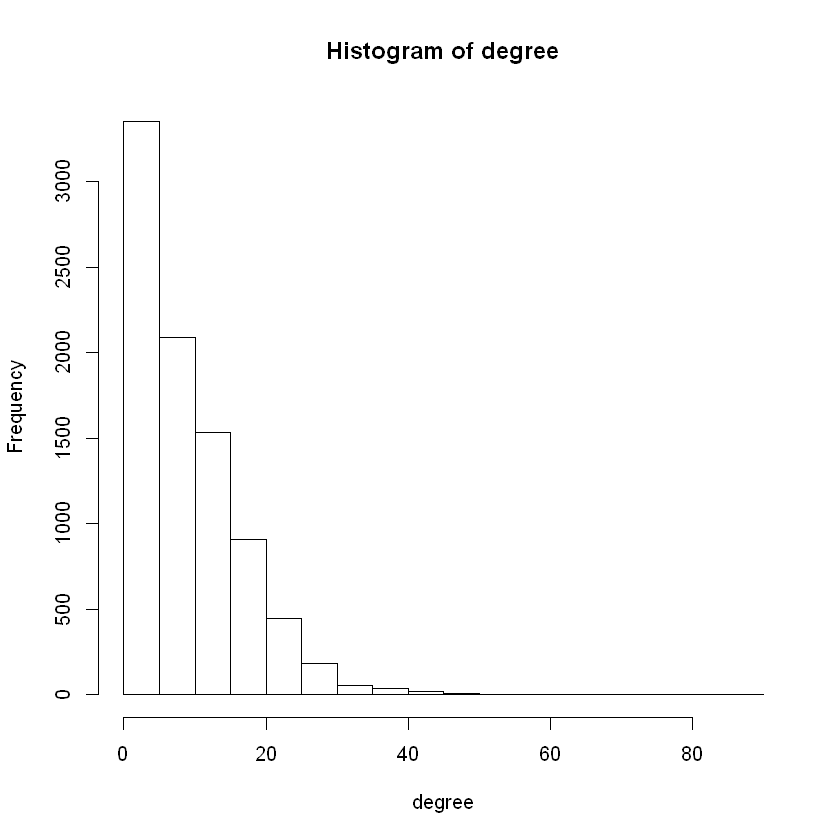

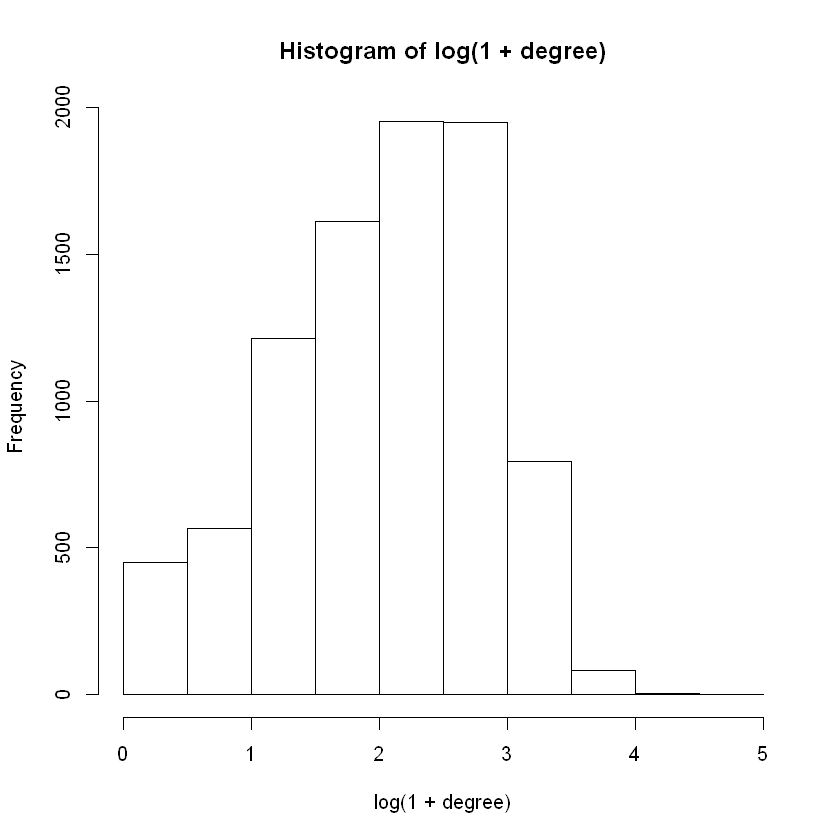

In [5]:
# Create degree from edges.
edges <- read.table("microfinance_edges.txt", colClasses="character")
household.net <- graph.edgelist(as.matrix(edges))
household.net <- as.undirected(household.net)
matches <- match(rownames(household), V(household.net)$name)
degree <- degree(household.net)[matches]
names(degree) <- rownames(household)
degree[is.na(degree)] <- 0

# Look at the distribution of degree
hist(degree)

# The distribution is left skewed.
# So normalize it by transforming to log(1+degree)
hist(log(1+degree))
degree<-log(1+degree)
degree<-as.data.frame(degree)

#### 2.  Confounder Effects
To estimate the confounder effects of control variables on degree, use a lasso regression model with 5-folds cross-validation to predict the degree from all of our control variables (village, religion, roof, rooms, beds, electricity, ownership, leader). Interact all controls with one another (~.^2).
<br>First split the data into 70% as training set and 30% testing set for the later model evaluation purpose. Explanatory variables are all controls and their interaction terms. Explained variable is degree (d). After fitting the model with training data, use the optimal lambda to predict the degree of households. Predicted degree of households is named as dhat. The Out of Sample R-squared of the prediction model is 0.0720.

In [6]:
# Create control variables.
controls <- subset(household,select = -c(loan))

# Create a matrix named x including all controls and all interactions.
# Drop the first column which is the intercept because glmnet by default includes intercept in regression.
x <- model.matrix(~ .^2,controls)[,-1]

# Create a matrix for degree named as d
d <- as.matrix(degree,ncol=1)

In [7]:
# Split the data into train and test set
set.seed(1234)
n <- nrow(x)
m = as.integer(0.7*n)									
ts = sample(1:n,m)						
x.train = x[ts,]							
d.train = d[ts]
x.test = x[-ts,]
d.test = d[-ts]

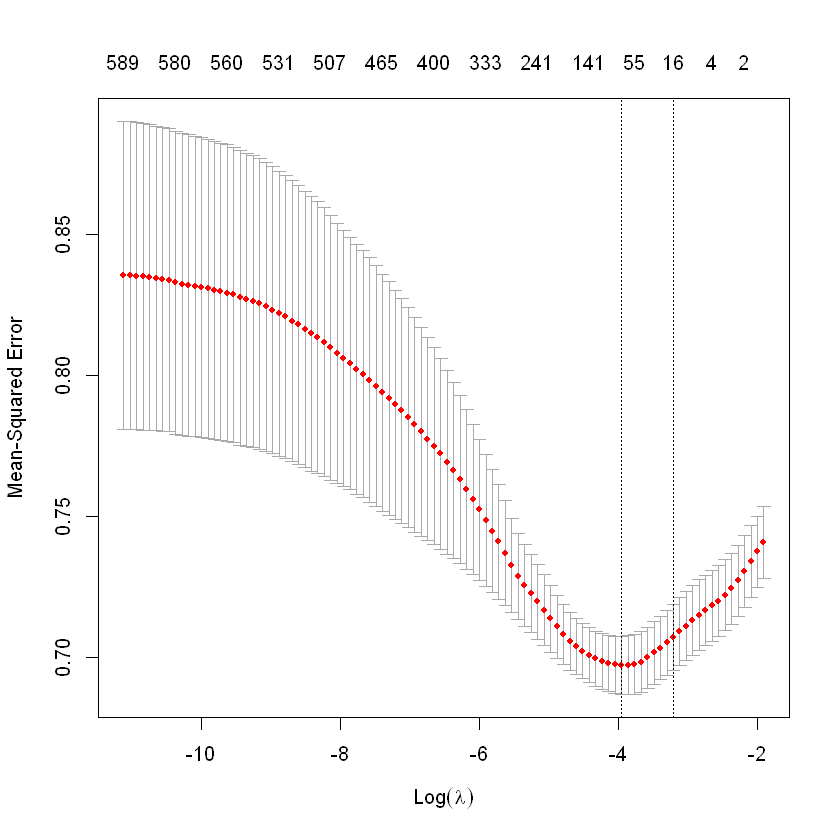

In [8]:
# Build a model to predict d from x, the control variables. Use lasso + CV.
# Use 5 folds cv
cvlasso.train <- cv.glmnet(x.train, d.train, nfolds = 5) 

# Us CV to find the "best" lambda
bestlambda_train_2<-cvlasso.train$lambda.min
plot(cvlasso.train)
dhat.test <- predict(cvlasso.train, s = bestlambda_train_2,newx = x.test)
colnames(dhat.test)<-"dhat.test"

In [9]:
# How tight the fit is? 
# Calculate the r-squared
rss.test <- sum((dhat.test - d.test) ^ 2)
tss.test <- sum((d.test - mean(d.test)) ^ 2)
rsq <- 1 - rss.test/tss.test
sprintf("OOS R Squared is: %f",rsq)

[1] "OOS R Squared is: 0.072048"

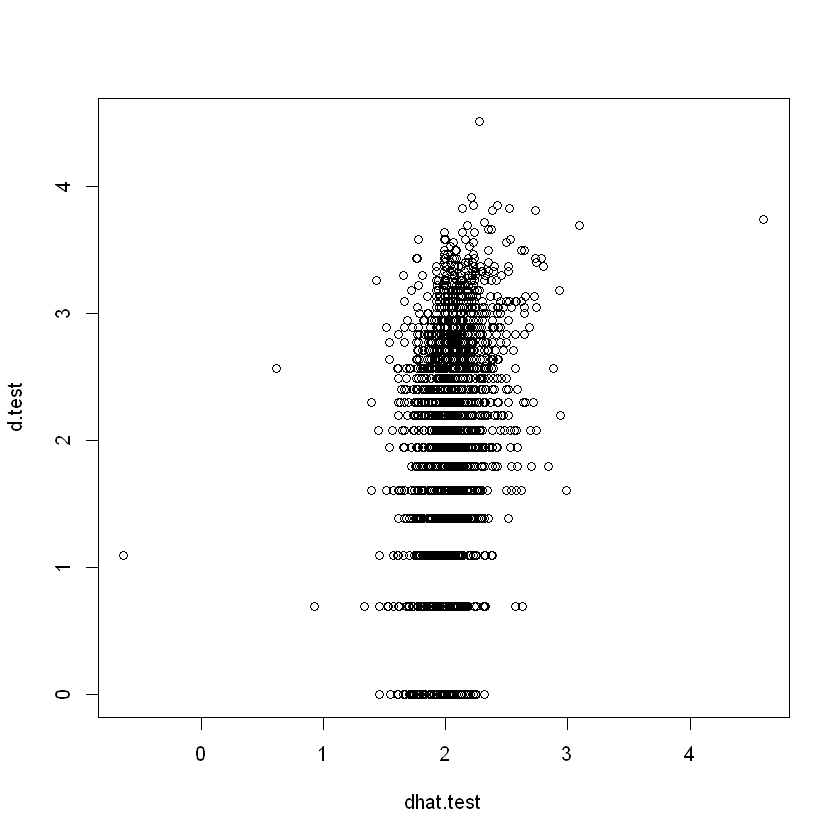

In [10]:
# plot dhat against d
plot(dhat.test,d.test)

# The fit is not tight. Degree is independent from controls. 

#### 3. Double-Lasso Model
Use predictions from [2] in an estimator for effect of d on loan. This is an application of a treatment effects lasso where estimated dhad obtained from lasso regression of d on x is included in the lasso regression of loan on [d, dhat, x] with dhat unpenalized. This ensures that confounder effects on d is removed and that the effect of treatement variable d is not shrinked. The best lambda is the lambda that minimizes the deviance of the logistic lasso model. Then we fit the model with the best lambda (0.00041) to evaluate the causal effect of d on loan. The coefficient of d is the estimate of d’s effect on loan.

In [11]:
# All samples are split into train and test set in the chunk above to see how much d is explained by x.
# However, to obtain all information of the part of d that is uncorrelated to x in the entire data set, 
# we need to predict dhat once again with x using all samples. 
cvlasso.all <- cv.glmnet(x, d, nfolds = 5) 
bestlambda_all_2<-cvlasso.all$lambda.min
dhat <- predict(cvlasso.all, s = bestlambda_all_2,newx = x)
colnames(dhat)<-"dhat"

In [12]:
# reg loan on d dhat x
loan <- subset(household,select = c(loan))
loan <- as.matrix(loan,ncol=1)
d_dhat_x <- cbind(d,dhat,x)

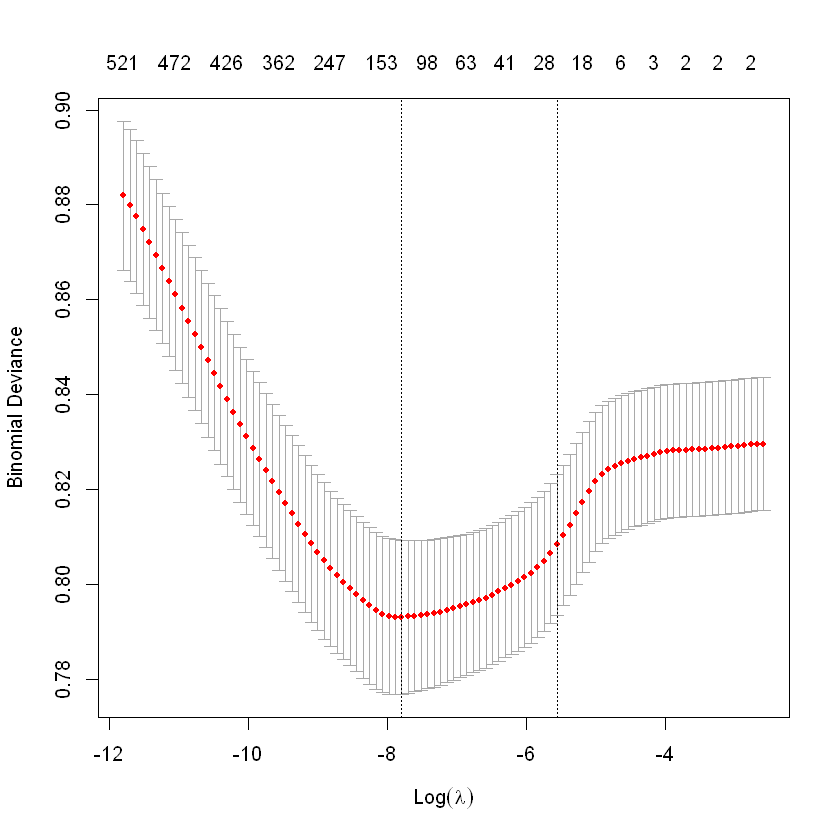

In [13]:
# with dhat UNPENALIZED 
factor <- c(rep(1, ncol(d)), rep(0, ncol(dhat)),rep(1, ncol(x)))
causal <- cv.glmnet(d_dhat_x, loan,
                 penalty.factor=factor,
                 family="binomial", standardize=FALSE,nfolds = 5)
plot(causal)

In [14]:
# Us CV to find the "best" lambda
bestlambda_3<-causal$lambda.min
# Effect
effect<-coef(causal,s="lambda.min")["degree",]
as.character(effect)
sprintf("Degree's effect on loan is: %f",effect)

[1] "0.178203698442646"

[1] "Degree's effect on loan is: 0.178204"

#### 4. Naive Lasso Model
Here, we compare the result of a naive lasso model and the double lasso model in [3]
We run a naive lasso for loan on d and x, which leads to d also being penalized by cost function because we don’t disentangle the part of d correlated with control variables from d. Also in the naive lasso model, we choose the best lambda according to AICc instead of cross-validation. The coefficient observed here is 0.172636 similar to that in [3]. This is because control variables can only explain 10% of d. In other words, d is relatively independent of control variables and so there’s not much confounder effect here. Even though the part of d correlated with control variables are penalized, the impact is neglectable. Therefore the result here is similar to that in double lasso.

In [15]:
d_x <- cbind(d,x)
naive <- glmnet(d_x, loan,
                family="binomial", standardize=FALSE)
deviance <- deviance(naive)
df <- naive$df
n <- naive$nobs
AICc <- deviance + 2*df*n/(n-df-1)
naive_effect<-coef(naive)['degree',][which.min(AICc)]
sprintf("Degree's effect on loan given by a naive lasso model is: %f",naive_effect)

[1] "Degree's effect on loan given by a naive lasso model is: 0.172636"

#### 5. Bootstrapping
Bootstrapping is a way to measure the estimate of the variable of interest by resampling our data with replacement. Here, we are measuring the estimator of our transformed variable “degree”. We run the sampling iterations 100 times and calculate coefficient of degree from the lasso model in [3]. The plot above shows the distribution of log-transformed degree. The mean is ~0 and sd ~ 0.035. We can conclude that the treatment effect ‘degree’ doesn’t affect the response i.e. whether a villager will get the loan or not. 

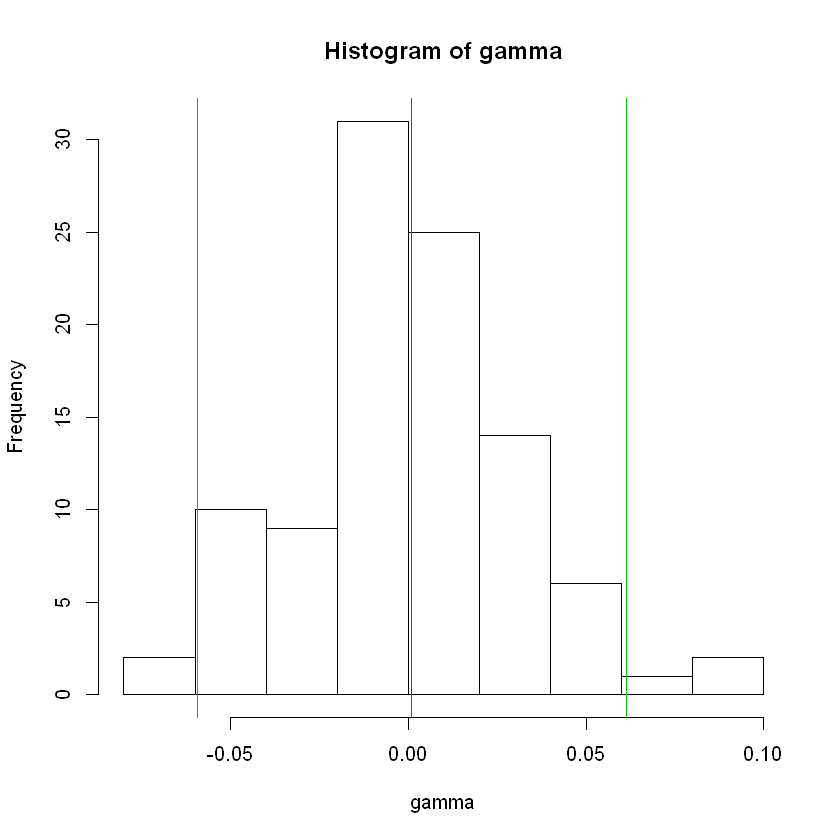

In [16]:
gamma <- c()
n <- nrow(x)
for (b in 1:100){
  ib <- sample(1:n,n,replace=TRUE)
  fb <- glmnet(d_dhat_x[ib,], loan,
               penalty.factor=factor,
               family="binomial", standardize=FALSE,
               lambda = bestlambda_3)
  gamma <- c(gamma, coef(fb)["degree",])
}

hist(gamma)
abline(v = mean(gamma),col = 2)
abline(v = mean(gamma) + 2*sd(gamma),col = 3)
abline(v = mean(gamma) - 2*sd(gamma),col = 3)